In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.base import (
    BaseEstimator, 
    TransformerMixin
)

from sklearn.model_selection import (
    train_test_split, 
    GridSearchCV, 
    RandomizedSearchCV, 
    cross_val_score
)

from sklearn.preprocessing import (
    OneHotEncoder, 
    OrdinalEncoder,
    LabelEncoder, 
    StandardScaler, 
    PolynomialFeatures
)

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score, 
    roc_auc_score, 
    classification_report, 
    confusion_matrix, 
    ConfusionMatrixDisplay, 
    precision_recall_curve, 
    roc_curve
)

from sklearn.feature_selection import (
    SelectKBest, 
    RFE, 
    f_classif
)

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from hyperopt import (
    fmin, 
    tpe, 
    hp, 
    Trials,
    STATUS_OK,
)

from hyperopt.pyll.base import scope

from typing import (
    Any, 
    Dict, 
    Union, 
    Sequence
)

import xgboost as xgb
from xgboost import XGBClassifier

from sklearn.svm import SVC

from loguru import logger
from joblib import dump, load

pd.set_option('display.max_columns', None)
from sklearn import set_config
set_config(transform_output='pandas')
pd.options.plotting.backend = 'matplotlib'

In [2]:
def pipe_logger(df, addon_msg=''):
    if addon_msg != '':
        logger.info(addon_msg)
    logger.info(f"Shape of DataFrame: {df.shape[0]} x {df.shape[1]}")
    return df

In [3]:
data = pd.read_csv('../../data/raw/hotel_reservations.csv')
data

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,INN00001,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.00,0,Not_Canceled
1,INN00002,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.68,1,Not_Canceled
2,INN00003,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.00,0,Canceled
3,INN00004,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,2018,5,20,Online,0,0,0,100.00,0,Canceled
4,INN00005,2,0,1,1,Not Selected,0,Room_Type 1,48,2018,4,11,Online,0,0,0,94.50,0,Canceled
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36270,INN36271,3,0,2,6,Meal Plan 1,0,Room_Type 4,85,2018,8,3,Online,0,0,0,167.80,1,Not_Canceled
36271,INN36272,2,0,1,3,Meal Plan 1,0,Room_Type 1,228,2018,10,17,Online,0,0,0,90.95,2,Canceled
36272,INN36273,2,0,2,6,Meal Plan 1,0,Room_Type 1,148,2018,7,1,Online,0,0,0,98.39,2,Not_Canceled
36273,INN36274,2,0,0,3,Not Selected,0,Room_Type 1,63,2018,4,21,Online,0,0,0,94.50,0,Canceled


In [4]:
(data
 .info()
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36275 entries, 0 to 36274
Data columns (total 19 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Booking_ID                            36275 non-null  object 
 1   no_of_adults                          36275 non-null  int64  
 2   no_of_children                        36275 non-null  int64  
 3   no_of_weekend_nights                  36275 non-null  int64  
 4   no_of_week_nights                     36275 non-null  int64  
 5   type_of_meal_plan                     36275 non-null  object 
 6   required_car_parking_space            36275 non-null  int64  
 7   room_type_reserved                    36275 non-null  object 
 8   lead_time                             36275 non-null  int64  
 9   arrival_year                          36275 non-null  int64  
 10  arrival_month                         36275 non-null  int64  
 11  arrival_date   

In [5]:
(data
 .describe()
)

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,required_car_parking_space,lead_time,arrival_year,arrival_month,arrival_date,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests
count,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000
mean,1.844962,0.105279,0.810724,2.204300,0.030986,85.232557,2017.820427,7.423653,15.596995,0.025637,0.023349,0.153411,103.423539,0.619655
std,0.518715,0.402648,0.870644,1.410905,0.173281,85.930817,0.383836,3.069894,8.740447,0.158053,0.368331,1.754171,35.089424,0.786236
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2017.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,0.000000,17.000000,2018.000000,5.000000,8.000000,0.000000,0.000000,0.000000,80.300000,0.000000
50%,2.000000,0.000000,1.000000,2.000000,0.000000,57.000000,2018.000000,8.000000,16.000000,0.000000,0.000000,0.000000,99.450000,0.000000
75%,2.000000,0.000000,2.000000,3.000000,0.000000,126.000000,2018.000000,10.000000,23.000000,0.000000,0.000000,0.000000,120.000000,1.000000
max,4.000000,10.000000,7.000000,17.000000,1.000000,443.000000,2018.000000,12.000000,31.000000,1.000000,13.000000,58.000000,540.000000,5.000000


In [6]:
(data
 ['booking_status']
 .value_counts(normalize=True, dropna=False))

booking_status
Not_Canceled    0.672364
Canceled        0.327636
Name: proportion, dtype: float64

In [7]:
label_encoder = LabelEncoder()
booking_status = pd.DataFrame(label_encoder.fit_transform(data['booking_status']), columns=['booking_status'])
booking_status

,booking_status
0,1
1,1
2,0
3,0
4,0
...,...
36270,1
36271,0
36272,1
36273,0


In [8]:
class TweakFeatures(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        
        return self
    
    def get_faulty_date_index(self, X: pd.DataFrame) -> pd.Index:
        
        return (X
                .loc[(X['arrival_year'] == 2018) & (X['arrival_month'] == 2) & (X['arrival_date'] == 29)]
                .index)
        
    def transform(self, X: pd.DataFrame, y=None) -> pd.DataFrame:
        
        return (X
                .pipe(pipe_logger)
                
                .drop(columns=['Booking_ID'])
                .pipe(lambda df_: df_.drop(self.get_faulty_date_index(df_))
                .pipe(pipe_logger, "After dropping leap year error...")
                .assign(date_combined=lambda df_: pd.to_datetime(df_['arrival_year'].astype(str) + '-' + df_['arrival_month'].astype(str) + '-' + df_['arrival_date'].astype(str)),
                        lead_time_category=lambda df_: np.where(df_['lead_time'].lt(90), 'Within 3 months', np.where(df_['lead_time'].lt(180), 'Within 6 months', 'Beyond 6 months')),
                        is_weekend_arrival=lambda df_: np.where(df_['date_combined'].dt.weekday.gt(5), 1, 0),
                        total_people=lambda df_: df_['no_of_adults'].add(df_['no_of_children']),
                        is_alone=lambda df_: np.where(df_['total_people'].eq(1), 1, 0),
                        total_nights_stay=lambda df_: df_['no_of_weekend_nights'].add(df_['no_of_week_nights']),
                        walk_in=lambda df_: np.where(df_['lead_time'].eq(0), 1, 0),
                        promotional_offer=lambda df_: np.where(df_['avg_price_per_room'].eq(0), 1, 0),
                        arrival_weekday=lambda df_: df_['date_combined'].dt.day_name(),
                        arrival_quarter=lambda df_: df_['date_combined'].dt.quarter,
                        week_of_year=lambda df_: df_['date_combined'].dt.isocalendar().week,)
                .drop(columns=['date_combined', 'arrival_year'])
                .astype({**{k: 'int8' 
                            for k in ['no_of_adults', 'no_of_children', 'no_of_weekend_nights', 'no_of_week_nights', 
                                      'no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled', 'no_of_special_requests', 'total_people', 'total_nights_stay',
                                      'arrival_month', 'arrival_date', 'arrival_quarter', 'week_of_year',
                                      'walk_in', 'promotional_offer', 'is_weekend_arrival', 'is_alone', 
                                      'required_car_parking_space', 'repeated_guest']},
                         **{k: 'int16'
                            for k in ['lead_time']},
                         **{k: 'category'
                            for k in ['type_of_meal_plan', 'room_type_reserved', 'market_segment_type', 'lead_time_category', 
                                      'arrival_weekday']},
                         'avg_price_per_room': 'float16',})
                ))

In [9]:
data = data.drop(columns=['booking_status'])

In [10]:
faulty_date_obs = TweakFeatures().get_faulty_date_index(data)

In [11]:
booking_status = booking_status.drop(index=faulty_date_obs)

In [12]:
data = TweakFeatures().transform(data)
data

2024-04-10 10:47:12.349 | INFO     | __main__:pipe_logger:4 - Shape of DataFrame: 36275 x 18
2024-04-10 10:47:12.356 | INFO     | __main__:pipe_logger:3 - After dropping leap year error...
2024-04-10 10:47:12.356 | INFO     | __main__:pipe_logger:4 - Shape of DataFrame: 36238 x 17


,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,lead_time_category,is_weekend_arrival,total_people,is_alone,total_nights_stay,walk_in,promotional_offer,arrival_weekday,arrival_quarter,week_of_year
0,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,10,2,Offline,0,0,0,65.0000,0,Beyond 6 months,0,2,0,3,0,0,Monday,4,40
1,2,0,2,3,Not Selected,0,Room_Type 1,5,11,6,Online,0,0,0,106.6875,1,Within 3 months,0,2,0,5,0,0,Tuesday,4,45
2,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2,28,Online,0,0,0,60.0000,0,Within 3 months,0,1,1,3,0,0,Wednesday,1,9
3,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,5,20,Online,0,0,0,100.0000,0,Beyond 6 months,1,2,0,2,0,0,Sunday,2,20
4,2,0,1,1,Not Selected,0,Room_Type 1,48,4,11,Online,0,0,0,94.5000,0,Within 3 months,0,2,0,2,0,0,Wednesday,2,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36270,3,0,2,6,Meal Plan 1,0,Room_Type 4,85,8,3,Online,0,0,0,167.7500,1,Within 3 months,0,3,0,8,0,0,Friday,3,31
36271,2,0,1,3,Meal Plan 1,0,Room_Type 1,228,10,17,Online,0,0,0,90.9375,2,Beyond 6 months,0,2,0,4,0,0,Wednesday,4,42
36272,2,0,2,6,Meal Plan 1,0,Room_Type 1,148,7,1,Online,0,0,0,98.3750,2,Within 6 months,1,2,0,8,0,0,Sunday,3,26
36273,2,0,0,3,Not Selected,0,Room_Type 1,63,4,21,Online,0,0,0,94.5000,0,Within 3 months,0,2,0,3,0,0,Saturday,2,16


In [13]:
ohe_categorical_features = ['type_of_meal_plan', 'room_type_reserved', 'market_segment_type', 'arrival_weekday']
ohe  = OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first').set_output(transform='pandas')

orde_categorical_features = ['lead_time_category']
orde = OrdinalEncoder().set_output(transform='pandas')

standard_numerical_features = ['lead_time', 'avg_price_per_room']
standard_scaler = StandardScaler().set_output(transform='pandas')

In [14]:
ohe_result = ohe.fit_transform(data[ohe_categorical_features])

In [15]:
orde_result = orde.fit_transform(data[orde_categorical_features])

In [16]:
data_transformed = pd.concat([data.drop(columns=['type_of_meal_plan', 'room_type_reserved', 'market_segment_type', 'arrival_weekday', 'lead_time_category']), 
                              ohe_result,
                              orde_result],
                              axis=1)

In [17]:
data_scaled = standard_scaler.fit_transform(data_transformed[standard_numerical_features])
data_transformed = data_transformed.drop(columns=['lead_time', 'avg_price_per_room'])
data_scaled = pd.concat([data_transformed, data_scaled], axis=1)
data_scaled

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,required_car_parking_space,arrival_month,arrival_date,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,no_of_special_requests,is_weekend_arrival,total_people,is_alone,total_nights_stay,walk_in,promotional_offer,arrival_quarter,week_of_year,type_of_meal_plan_Meal Plan 2,type_of_meal_plan_Meal Plan 3,type_of_meal_plan_Not Selected,room_type_reserved_Room_Type 2,room_type_reserved_Room_Type 3,room_type_reserved_Room_Type 4,room_type_reserved_Room_Type 5,room_type_reserved_Room_Type 6,room_type_reserved_Room_Type 7,market_segment_type_Complementary,market_segment_type_Corporate,market_segment_type_Offline,market_segment_type_Online,arrival_weekday_Monday,arrival_weekday_Saturday,arrival_weekday_Sunday,arrival_weekday_Thursday,arrival_weekday_Tuesday,arrival_weekday_Wednesday,lead_time_category,lead_time,avg_price_per_room
0,2,0,1,2,0,10,2,0,0,0,0,0,2,0,3,0,0,4,40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.613974,-1.095601
1,2,0,2,3,0,11,6,0,0,0,1,0,2,0,5,0,0,4,45,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,-0.933948,0.092654
2,1,0,2,1,0,2,28,0,0,0,0,0,1,1,3,0,0,1,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-0.980486,-1.238121
3,2,0,0,2,0,5,20,0,0,0,0,1,2,0,2,0,0,2,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.462728,-0.097966
4,2,0,1,1,0,4,11,0,0,0,0,0,2,0,2,0,0,2,15,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-0.433671,-0.254737
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36270,3,0,2,6,0,8,3,0,0,0,1,0,3,0,8,0,0,3,31,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.003200,1.833172
36271,2,0,1,3,0,10,17,0,0,0,2,0,2,0,4,0,0,4,42,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.660512,-0.356282
36272,2,0,2,6,0,7,1,0,0,0,2,1,2,0,8,0,0,3,26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.729764,-0.144284
36273,2,0,0,3,0,4,21,0,0,0,0,0,2,0,3,0,0,2,16,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,-0.259156,-0.254737


In [18]:
X_train, X_test, y_train, y_test = train_test_split(data_scaled, 
                                                    booking_status, 
                                                    test_size=0.2, 
                                                    stratify=booking_status,
                                                    random_state=42)

In [19]:
logreg_oob = LogisticRegression(solver='liblinear',
                                random_state=42)
logreg_oob.fit(data_scaled,
               booking_status.values.ravel())

LogisticRegression(random_state=42, solver='liblinear')

In [20]:
y_pred = logreg_oob.predict(X_test)
y_pred

array([0, 1, 1, ..., 1, 0, 0])

In [21]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC:", roc_auc)

Accuracy: 0.8027041942604857
Precision: 0.8324961360123647
Recall: 0.8844417077175698
F1 Score: 0.8576831210191083
ROC AUC: 0.75977135890929


In [22]:
print(classification_report(label_encoder.inverse_transform(y_test.values.ravel()), label_encoder.inverse_transform(y_pred)))

              precision    recall  f1-score   support

    Canceled       0.73      0.64      0.68      2376
Not_Canceled       0.83      0.88      0.86      4872

    accuracy                           0.80      7248
   macro avg       0.78      0.76      0.77      7248
weighted avg       0.80      0.80      0.80      7248



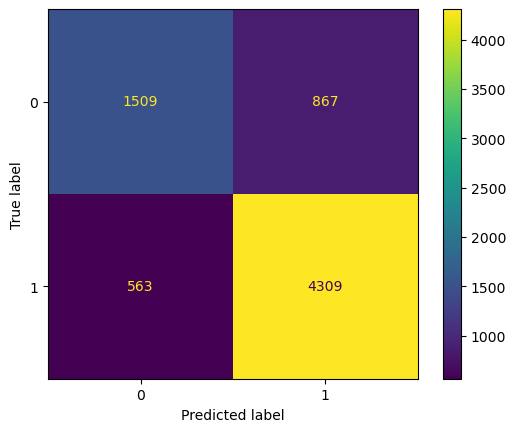

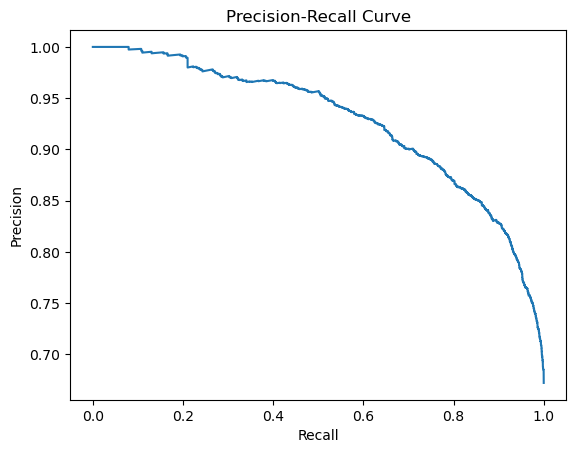

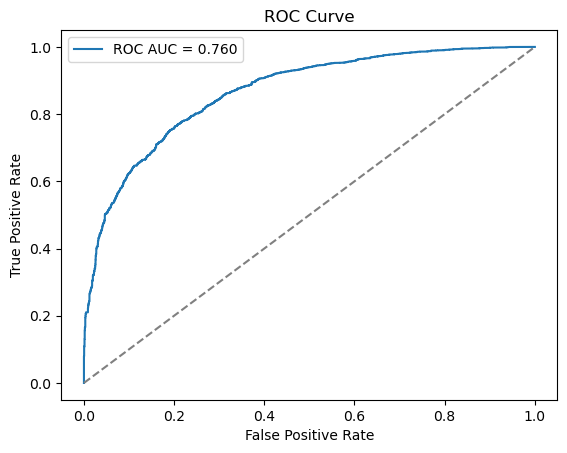

In [23]:
# Confusion Matrix
y_pred = logreg_oob.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, logreg_oob.predict_proba(X_test)[:, 1])  # Positive class probability
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

# ROC AUC Curve
fpr, tpr, _ = roc_curve(y_test, logreg_oob.predict_proba(X_test)[:, 1])  # Positive class probability
roc_auc = roc_auc_score(y_test, y_pred) 
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.3f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')  # Baseline
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [18]:
data_poly = PolynomialFeatures(degree=2, 
                               interaction_only=False, 
                               include_bias=True).set_output(transform='pandas').fit_transform(data_scaled)
data_poly

1  no_of_adults  no_of_children  no_of_weekend_nights  \
0      1.0           2.0             0.0                   1.0   
1      1.0           2.0             0.0                   2.0   
2      1.0           1.0             0.0                   2.0   
3      1.0           2.0             0.0                   0.0   
4      1.0           2.0             0.0                   1.0   
...    ...           ...             ...                   ...   
36270  1.0           3.0             0.0                   2.0   
36271  1.0           2.0             0.0                   1.0   
36272  1.0           2.0             0.0                   2.0   
36273  1.0           2.0             0.0                   0.0   
36274  1.0           2.0             0.0                   1.0   

       no_of_week_nights  required_car_parking_space  arrival_month  \
0                    2.0                         0.0           10.0   
1                    3.0                         0.0           11.0   
2                    1.0                         0.0            2.0   
3                    2.0                         0.0            5.0   
4                    1.0                         0.0            4.0   
...                  ...                         ...            ...   
36270                6.0                         0.0            8.0   
36271                3.0                         0.0           10.0   
36272                6.0                         0.0            7.0   
36273                3.0                         0.0            4.0   
36274                2.0                         0.0           12.0   

       arrival_date  repeated_guest  no_of_previous_cancellations  \
0               2.0             0.0                           0.0   
1               6.0             0.0                           0.0   
2              28.0             0.0                           0.0   
3              20.0             0.0                           0.0   
4              11.0             0.0                           0.0   
...             ...             ...                           ...   
36270           3.0             0.0                           0.0   
36271          17.0             0.0                           0.0   
36272           1.0             0.0                           0.0   
36273          21.0             0.0                           0.0   
36274          30.0             0.0                           0.0   

       no_of_previous_bookings_not_canceled  no_of_special_requests  \
0                                       0.0                     0.0   
1                                       0.0                     1.0   
2                                       0.0                     0.0   
3                                       0.0                     0.0   
4                                       0.0                     0.0   
...                                     ...                     ...   
36270                                   0.0                     1.0   
36271                                   0.0                     2.0   
36272                                   0.0                     2.0   
36273                                   0.0                     0.0   
36274                                   0.0                     0.0   

       is_weekend_arrival  total_people  is_alone  total_nights_stay  walk_in  \
0                     0.0           2.0       0.0                3.0      0.0   
1                     0.0           2.0       0.0                5.0      0.0   
2                     0.0           1.0       1.0                3.0      0.0   
3                     1.0           2.0       0.0                2.0      0.0   
4                     0.0           2.0       0.0                2.0      0.0   
...                   ...           ...       ...                ...      ...   
36270                 0.0           3.0       0.0                8.0      0.0   
36271                 0.0        

In [19]:
X_train, X_test, y_train, y_test = train_test_split(data_poly, 
                                                    booking_status, 
                                                    test_size=0.2, 
                                                    stratify=booking_status,
                                                    random_state=42)

In [21]:
X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                  y_train, 
                                                  test_size=0.2, 
                                                  stratify=y_train,
                                                  random_state=42)

In [27]:
logreg_poly = LogisticRegression(solver='liblinear',
                                 random_state=42)
logreg_poly.fit(data_poly,
                booking_status.values.ravel())# 

/Users/andreaslukita7/Data/DSA_ML/Python/Analysis/hotel_reservation/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LogisticRegression(random_state=42, solver='liblinear')

In [28]:
y_pred = logreg_poly.predict(X_test)
y_pred

array([0, 1, 1, ..., 1, 0, 1])

In [29]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC:", roc_auc)

Accuracy: 0.8389900662251656
Precision: 0.8643067846607669
Recall: 0.9020935960591133
F1 Score: 0.8827960228984634
ROC AUC: 0.8058447778275364


In [30]:
print(classification_report(label_encoder.inverse_transform(y_test.values.ravel()), label_encoder.inverse_transform(y_pred)))

              precision    recall  f1-score   support

    Canceled       0.78      0.71      0.74      2376
Not_Canceled       0.86      0.90      0.88      4872

    accuracy                           0.84      7248
   macro avg       0.82      0.81      0.81      7248
weighted avg       0.84      0.84      0.84      7248



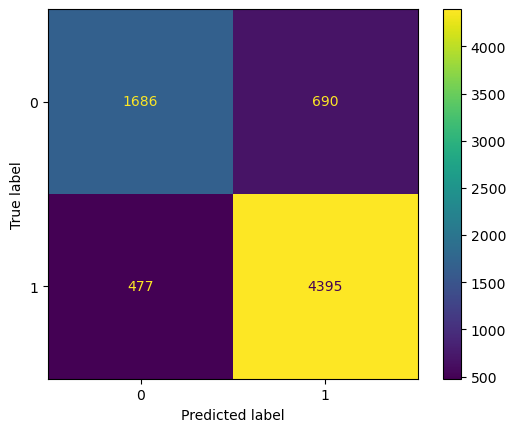

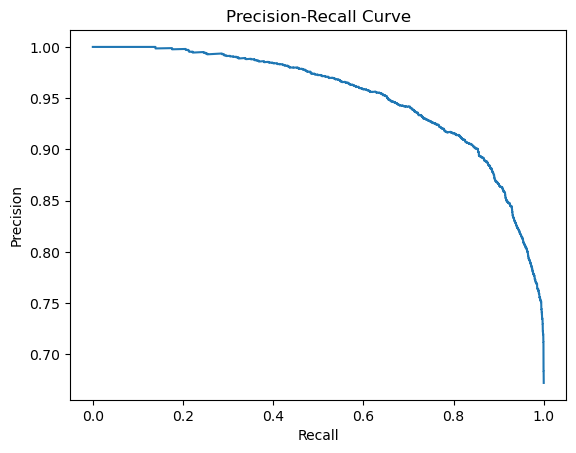

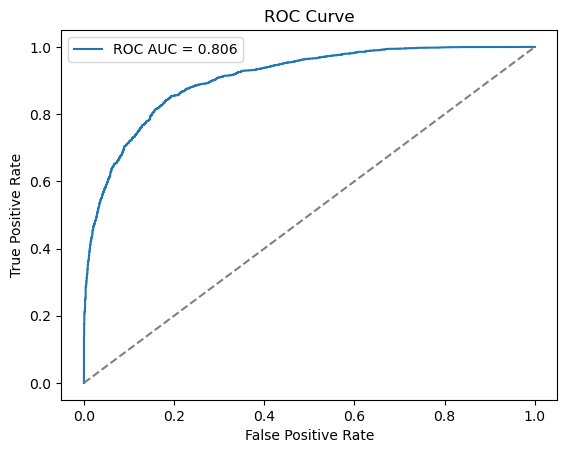

In [31]:
# Confusion Matrix
y_pred = logreg_poly.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, logreg_poly.predict_proba(X_test)[:, 1])  # Positive class probability
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

# ROC AUC Curve
fpr, tpr, _ = roc_curve(y_test, logreg_poly.predict_proba(X_test)[:, 1])  # Positive class probability
roc_auc = roc_auc_score(y_test, y_pred) 
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.3f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')  # Baseline
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [35]:
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.01, 0.1, 1],
    'solver': ['liblinear', 'saga'],
    'max_iter': [1000]
}

In [36]:
grid_search = GridSearchCV(estimator=logreg_poly, 
                           param_grid=param_grid, 
                           cv=5, 
                           n_jobs=-1)

In [37]:
grid_search.fit(data_poly, booking_status.values.ravel())

best_model = grid_search.best_estimator_
print(grid_search.best_params_)  # Best hyperparameter combination found
print(grid_search.best_score_)  # Best performance metric achieved

/Users/andreaslukita7/Data/DSA_ML/Python/Analysis/hotel_reservation/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/andreaslukita7/Data/DSA_ML/Python/Analysis/hotel_reservation/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/andreaslukita7/Data/DSA_ML/Python/Analysis/hotel_reservation/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/andreaslukita7/Data/DSA_ML/Python/Analysis/hotel_reservation/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/andreaslukita7/Data/DSA_ML/Python/Analysis/ho

{'C': 0.1, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'liblinear'}
0.8355038782889836


In [38]:
y_pred = grid_search.best_estimator_.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC:", roc_auc)

Accuracy: 0.839817880794702
Precision: 0.8643235813862163
Recall: 0.9035303776683087
F1 Score: 0.883492222779729
ROC AUC: 0.8063527309216963


In [39]:
print(classification_report(label_encoder.inverse_transform(y_test.values.ravel()), label_encoder.inverse_transform(y_pred)))

              precision    recall  f1-score   support

    Canceled       0.78      0.71      0.74      2376
Not_Canceled       0.86      0.90      0.88      4872

    accuracy                           0.84      7248
   macro avg       0.82      0.81      0.81      7248
weighted avg       0.84      0.84      0.84      7248



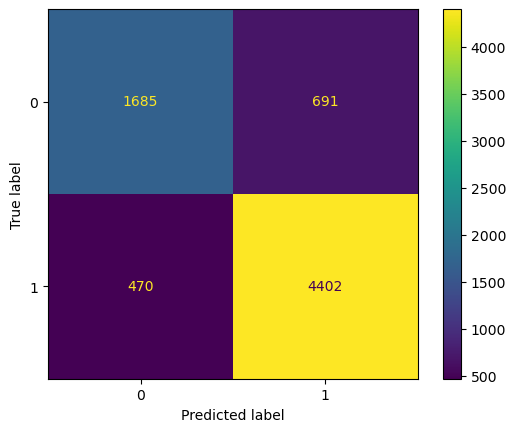

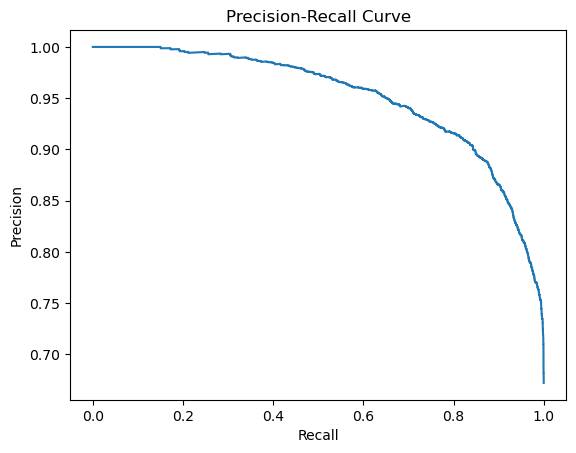

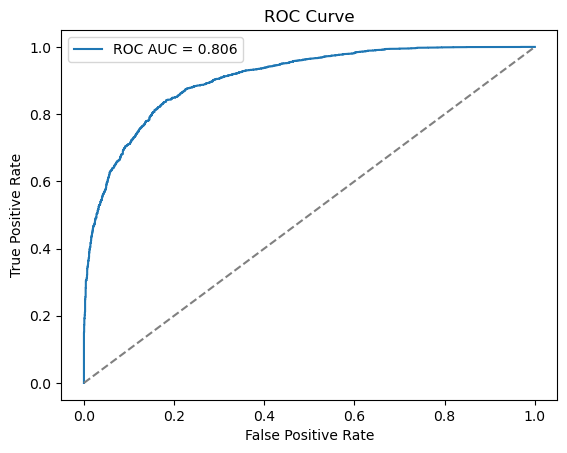

In [40]:
# Confusion Matrix
y_pred = grid_search.best_estimator_.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, grid_search.best_estimator_.predict_proba(X_test)[:, 1])  # Positive class probability
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

# ROC AUC Curve
fpr, tpr, _ = roc_curve(y_test, grid_search.best_estimator_.predict_proba(X_test)[:, 1])  # Positive class probability
roc_auc = roc_auc_score(y_test, y_pred) 
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.3f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')  # Baseline
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# XGBoost

In [40]:
def hyperparameter_tuning(space: Dict[str, Union[float, int]],
                          X_train: pd.DataFrame, 
                          y_train: pd.Series,
                          X_val: pd.DataFrame,
                          y_val: pd.Series,
                          early_stopping_rounds: int=100,
                          metric:callable=roc_auc_score) -> Dict[str, Any]:
    
    int_vals = ['max_depth']
    space = {k: (int (val) if k in int_vals else val)
             for k, val in space.items()}
    # space['early_stopping_rounds'] = early_stopping_rounds
    
    model = XGBClassifier(**space, 
                        #   eval_metric=['aucpr'],
                          seed=42,
                          n_jobs=-1)
    
    model.fit(X_train, 
              y_train, 
            #   eval_set=[(X_train, y_train),
            #             (X_val, y_val)],
              verbose=False)
    
    pred = model.predict(X_val)
    score = metric(y_val, pred)
    
    return {'loss': score, 'status': STATUS_OK, 'model': model}

In [28]:
@scope.define
def to_int(x):
    return int(x)

In [36]:
options = {'n_estimators': hp.choice('n_estimators', [500, 1000]),
           'max_depth': scope.to_int(hp.quniform('max_depth', 10, 80, 1)),
           'min_child_weight': hp.loguniform('min_child_weight', -1, 1),
           'subsample': hp.uniform('subsample', 0.5, 1),
           'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
           'gamma': hp.loguniform('gamma', -10, 10),
           'learning_rate': hp.loguniform('learning_rate', -7, 0),
           'random_state': 42
          }

In [41]:
trials = Trials()
SEED=101

xgb_best_params = fmin(fn=lambda space: hyperparameter_tuning(space, 
                                                              data_poly, 
                                                              booking_status.values.ravel(),
                                                              X_val,
                                                              y_val),
                       space=options,
                       algo=tpe.suggest,
                       max_evals=10,
                       trials=trials,
                       rstate=np.random.default_rng(SEED))

100%|██████████| 10/10 [40:03<00:00, 240.30s/trial, best loss: 0.978770219545786]


In [42]:
xgb_best_params

{'colsample_bytree': 0.6529939456579166,
 'gamma': 1.9850504625046277,
 'learning_rate': 0.023776786537981036,
 'max_depth': 39.0,
 'min_child_weight': 1.4978036162905206,
 'n_estimators': 0,
 'subsample': 0.550446925513125}

In [43]:
xgb_best_params = {
    'n_estimators': 500,
    'colsample_bytree': xgb_best_params['colsample_bytree'],
    'gamma': xgb_best_params['gamma'],
    'learning_rate': xgb_best_params['learning_rate'],
    'max_depth': int(xgb_best_params['max_depth']),
    'min_child_weight': xgb_best_params['min_child_weight'],
    'subsample': xgb_best_params['subsample'],
    'random_state': 42
}

In [52]:
xgb_clf_tuned = XGBClassifier(**xgb_best_params, 
                              objective='binary:logistic', 
                              n_jobs=-1,
                              seed=42)

xgb_clf_tuned.fit(pd.concat([X_train, X_val], axis=0), pd.concat([y_train, y_val], axis=0))
y_pred = xgb_clf_tuned.predict(X_val)

In [54]:
print(f'Accuracy score: {accuracy_score(y_val, xgb_clf_tuned.predict(X_val))}')
print(f'Precision score: {precision_score(y_val, xgb_clf_tuned.predict(X_val))}')
print(f'Recall score: {recall_score(y_val, xgb_clf_tuned.predict(X_val))}')
print(f'F1 score: {f1_score(y_val, xgb_clf_tuned.predict(X_val))}')
print(f'ROC-AUC score: {roc_auc_score(y_val, xgb_clf_tuned.predict_proba(X_val)[:, 1])}')

Accuracy score: 0.984304932735426
Precision score: 0.9817767653758542
Recall score: 0.9951257054899949
F1 score: 0.9884061663906231
ROC-AUC score: 0.9984215252086089


In [55]:
print(classification_report(label_encoder.inverse_transform(y_val.values.ravel()), label_encoder.inverse_transform(y_pred)))

              precision    recall  f1-score   support

    Canceled       0.99      0.96      0.98      1900
Not_Canceled       0.98      1.00      0.99      3898

    accuracy                           0.98      5798
   macro avg       0.99      0.98      0.98      5798
weighted avg       0.98      0.98      0.98      5798



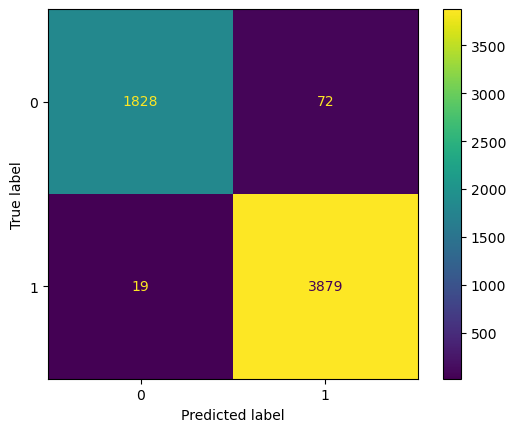

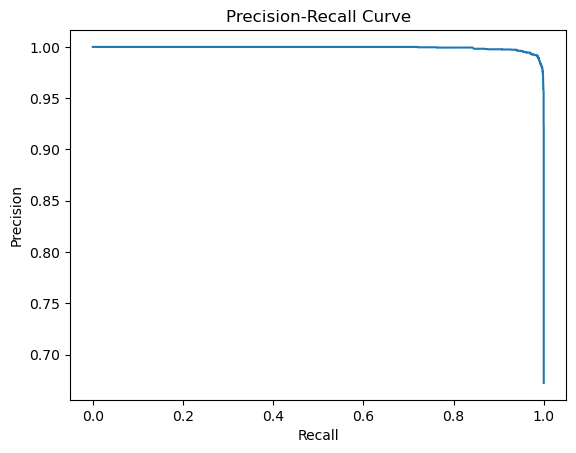

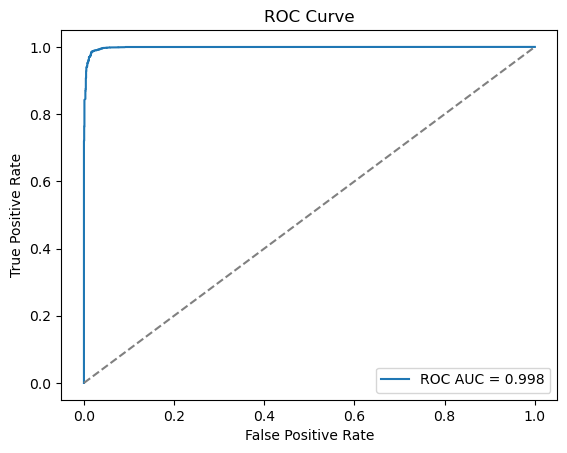

In [56]:
# Confusion Matrix
y_pred = xgb_clf_tuned.predict(X_val)
cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_val, xgb_clf_tuned.predict_proba(X_val)[:, 1])  # Positive class probability
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

# ROC AUC Curve
fpr, tpr, _ = roc_curve(y_val, xgb_clf_tuned.predict_proba(X_val)[:, 1])  # Positive class probability
roc_auc = roc_auc_score(y_val, xgb_clf_tuned.predict_proba(X_val)[:, 1]) 
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.3f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')  # Baseline
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [57]:
model_to_dump = xgb_clf_tuned
dump(model_to_dump, '../../models/data_leakage.joblib')

['../../models/data_leakage.joblib']

In [58]:
xgb_clf_tuned = XGBClassifier(**xgb_best_params, 
                              objective='binary:logistic', 
                              n_jobs=-1,
                              seed=42)

xgb_clf_tuned.fit(X_train, y_train)
y_pred = xgb_clf_tuned.predict(X_test)

In [59]:
print(f'Accuracy score: {accuracy_score(y_test, xgb_clf_tuned.predict(X_test))}')
print(f'Precision score: {precision_score(y_test, xgb_clf_tuned.predict(X_test))}')
print(f'Recall score: {recall_score(y_test, xgb_clf_tuned.predict(X_test))}')
print(f'F1 score: {f1_score(y_test, xgb_clf_tuned.predict(X_test))}')
print(f'ROC-AUC score: {roc_auc_score(y_test, xgb_clf_tuned.predict_proba(X_test)[:, 1])}')

Accuracy score: 0.8976269315673289
Precision score: 0.9097222222222222
Recall score: 0.9410919540229885
F1 score: 0.9251412429378532
ROC-AUC score: 0.9548196887456945


In [60]:
print(classification_report(label_encoder.inverse_transform(y_test.values.ravel()), label_encoder.inverse_transform(y_pred)))

              precision    recall  f1-score   support

    Canceled       0.87      0.81      0.84      2376
Not_Canceled       0.91      0.94      0.93      4872

    accuracy                           0.90      7248
   macro avg       0.89      0.87      0.88      7248
weighted avg       0.90      0.90      0.90      7248



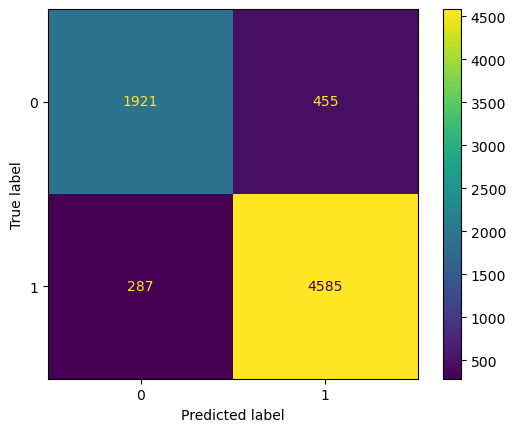

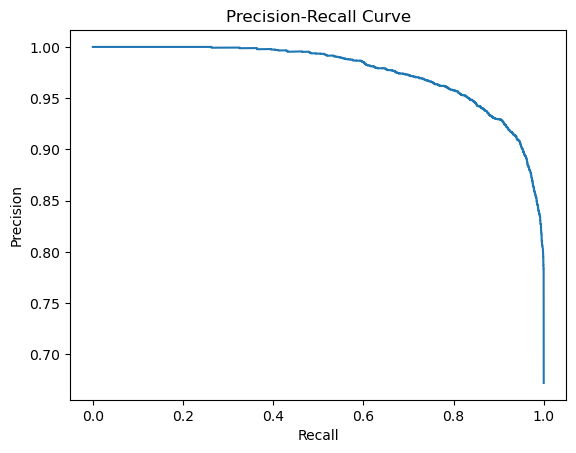

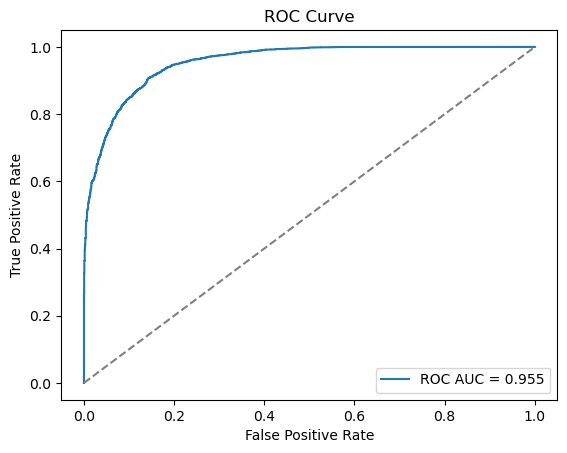

In [61]:
# Confusion Matrix
y_pred = xgb_clf_tuned.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, xgb_clf_tuned.predict_proba(X_test)[:, 1])  # Positive class probability
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

# ROC AUC Curve
fpr, tpr, _ = roc_curve(y_test, xgb_clf_tuned.predict_proba(X_test)[:, 1])  # Positive class probability
roc_auc = roc_auc_score(y_test, xgb_clf_tuned.predict_proba(X_test)[:, 1]) 
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.3f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')  # Baseline
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [62]:
import seaborn.objects as so

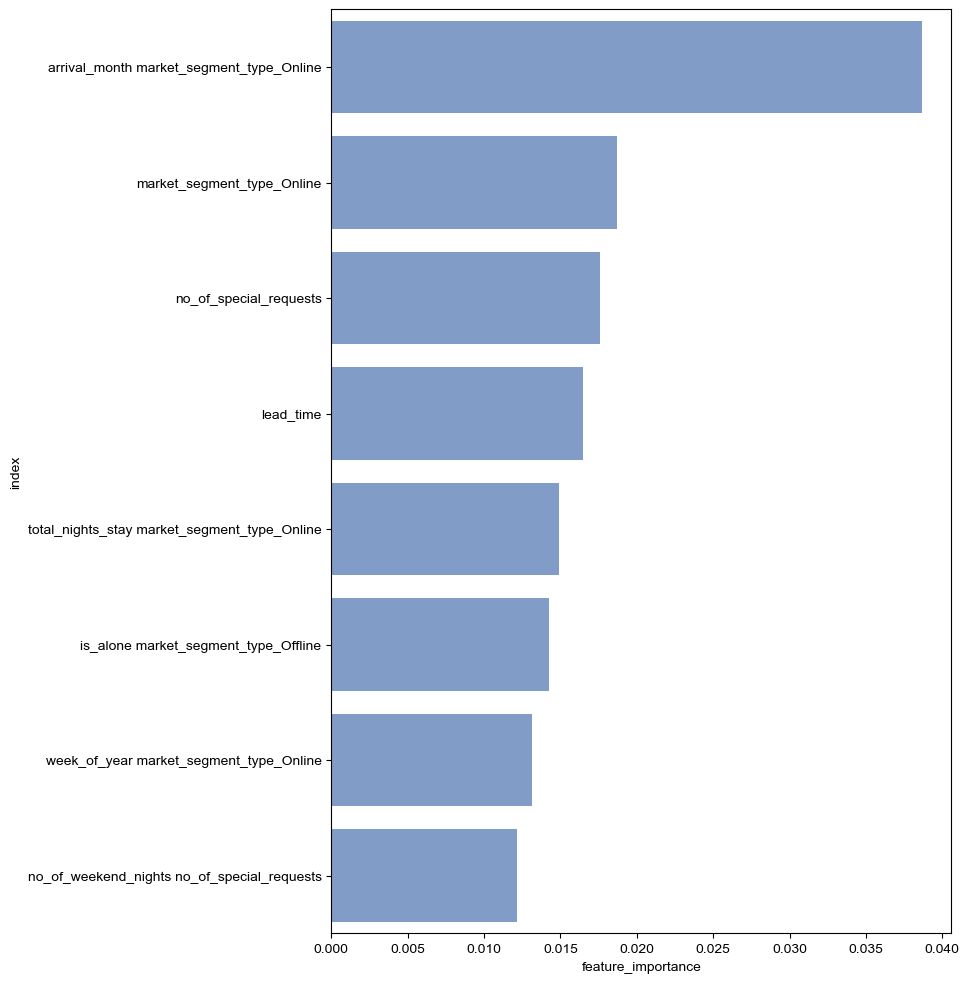

In [63]:
fig, ax = plt.subplots(figsize=(8, 12))
(so
 .Plot((pd
      .DataFrame(xgb_clf_tuned.feature_importances_, index=X_train.columns.tolist())
      .rename(columns={0: "feature_importance"})
      .sort_values(by="feature_importance", ascending=False)
      .iloc[:8, :]
      .reset_index()),
     x='feature_importance',
     y='index'
    )
 .add(so.Bar(edgewidth=0))
#  .theme({"axes.prop_cycle": matplotlib.cycler(color="#1155ccff")})
 .on(ax)
 .show())

In [77]:
np.array([1,1,1])

array([1, 1, 1])

In [78]:
confusion_matrix(np.array([1,1,0]), np.array([1,1,0]))

array([[1, 0],
       [0, 2]])